In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from utils.logger import get_logger
_logs = get_logger(__name__)

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

In [3]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(os.path.join(ft_dir, '**/*.parquet'), 
               recursive = True)
df = dd.read_parquet(ft_glob).compute().reset_index()

# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [4]:
df

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1
0,ACN,2001-07-19,15.10,15.29,15.00,15.17,11.404394,34994300.0,ACN.csv,2001,NaN
1,ACN,2001-07-20,15.05,15.05,14.80,15.01,11.284108,9238500.0,ACN.csv,2001,15.17
2,ACN,2001-07-23,15.00,15.01,14.55,15.00,11.276587,7501000.0,ACN.csv,2001,15.01
3,ACN,2001-07-24,14.95,14.97,14.70,14.86,11.171341,3537300.0,ACN.csv,2001,15.00
4,ACN,2001-07-25,14.70,14.95,14.65,14.95,11.238999,4208100.0,ACN.csv,2001,14.86
...,...,...,...,...,...,...,...,...,...,...,...
353650,ZIXI,2003-12-24,7.65,7.96,7.50,7.74,7.740000,236300.0,ZIXI.csv,2003,7.62
353651,ZIXI,2003-12-26,7.90,8.13,7.80,8.06,8.060000,144200.0,ZIXI.csv,2003,7.74
353652,ZIXI,2003-12-29,8.00,8.10,7.81,7.88,7.880000,245400.0,ZIXI.csv,2003,8.06
353653,ZIXI,2003-12-30,7.90,8.36,7.78,8.26,8.260000,372300.0,ZIXI.csv,2003,7.88


In [10]:
df.sample(n = 25)

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1
32814,ALL,2009-04-29,22.320000,22.950001,22.120001,22.920000,17.988813,6830500.0,ALL.csv,2009,22.240000
332668,VIAC,2017-05-18,60.529999,61.139999,60.250000,60.380001,59.236759,4385300.0,VIAC.csv,2017,60.380001
323420,UMBF,2014-10-20,54.000000,54.580002,53.799999,54.439999,49.564014,155900.0,UMBF.csv,2014,54.270000
318724,UMBF,1996-02-26,14.233687,14.233687,14.233687,14.233687,9.225294,7000.0,UMBF.csv,1996,15.215322
59287,BJRI,2014-03-31,32.730000,33.049999,32.410000,32.709999,31.827244,269400.0,BJRI.csv,2014,32.490002
72285,CBB,2004-02-27,26.400000,26.450001,25.250000,25.750000,25.750000,264100.0,CBB.csv,2004,26.650000
309259,TSN,2006-03-03,13.590000,13.590000,13.330000,13.340000,11.195364,1878300.0,TSN.csv,2006,13.620000
38100,APPS,2008-01-16,18.750000,18.750000,18.750000,18.750000,18.750000,0.0,APPS.csv,2008,18.750000
311136,TSN,2013-08-16,31.370001,31.610001,31.350000,31.440001,28.490540,2986200.0,TSN.csv,2013,31.469999
323294,UMBF,2014-04-22,60.580002,61.299999,60.380001,60.520000,54.678078,184100.0,UMBF.csv,2014,60.869999


In [11]:
import random
random.seed(42)
sample_tickers = random.sample(df['ticker'].unique().tolist(), 30)
df = df[df['ticker'].isin(sample_tickers)]
simple_sample_dt = df.sample(frac = 0.1)
simple_sample_dt.shape, df.shape

((12077, 11), (120770, 11))

Look at the distribution of tickers.

<Axes: xlabel='ticker'>

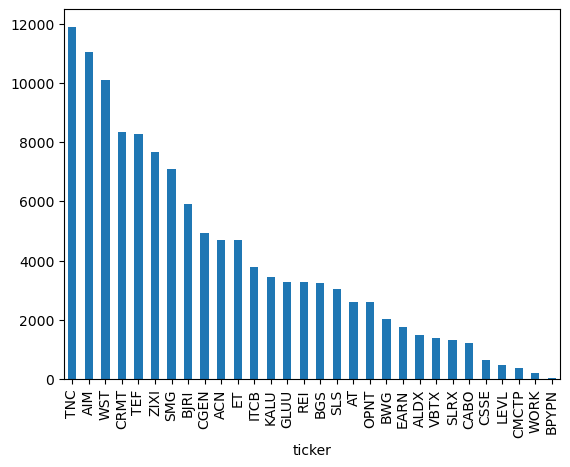

In [14]:
df['ticker'].value_counts().plot(kind='bar')

<Axes: xlabel='ticker'>

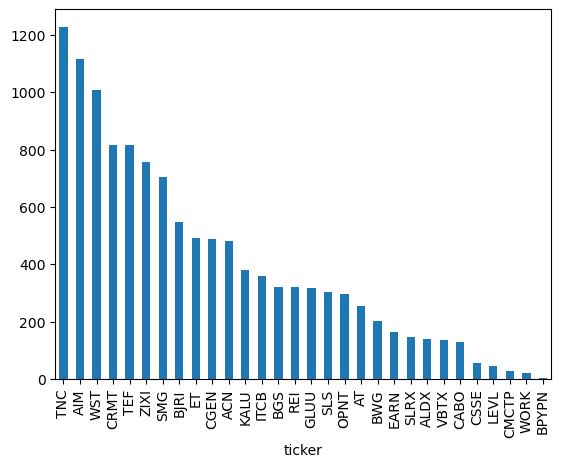

In [15]:
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

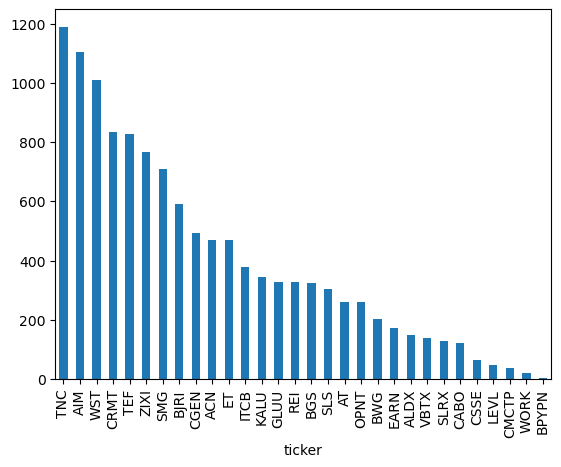

In [16]:
strat_sample_dt = df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

C:\Users\JesusCalderon\AppData\Local\Temp\ipykernel_13888\1783207470.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd = (dd_dt


<Axes: xlabel='ticker'>

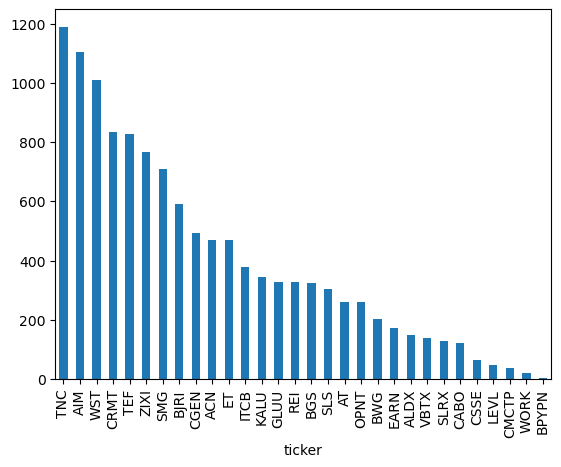

In [17]:
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1))
                      .compute()
                      .reset_index())
strat_sample_dd[strat_sample_dd['ticker'].isin(sample_tickers)]['ticker'].value_counts().plot(kind='bar')